## Implement the Gaussian process by using the exponential-quadratic kernel function

In [15]:
## import lib
import pandas as pd
import numpy as np
from numpy.linalg import pinv,inv,matrix_power
from scipy.linalg import sqrtm
from scipy.io import loadmat
import itertools
import math

In [16]:
## load data
data_dir = './Dataset/'
x = loadmat(data_dir+'2_data.mat')['x']
t = loadmat(data_dir+'2_data.mat')['t']
x_tr = sorted(x[:60])
x_ts = sorted(x[60:])
t_tr = [x for _,x in sorted(zip(x[:60],t[:60]))]
t_ts = [x for _,x in sorted(zip(x[60:],t[60:]))]
print('x-type : %s %s' % (type(x), type(x[0][0])))
print('x-shape : ',x.shape)
print('t-type : %s %s' % (type(t), type(t[0][0])))
print('t-shape : ',t.shape)
# print(x[:3])

# Setting kernel
sqr_exp_kernel = [1.0,4.0,0.0,0.0]
linear_kernel = [0.0,0.0,0.0,1.0]
exp_quadra_kernel = [1.0,4.0,0.0,5.0]
exp_quadra_kernel_2 = [1.0,64.0,10.0,0.0]
kernel_dic = {'sqr_exp_kernel':[1,4,0,0], 'linear_kernel':[0,0,0,1], 'exp_quadra_kernel':[1,4,0,5], 'exp_quadra_kernel_2':[1,64,10,0]}

# Setting basic para.
beta= 1

x-type : <class 'numpy.ndarray'> <class 'numpy.float64'>
x-shape :  (100, 1)
t-type : <class 'numpy.ndarray'> <class 'numpy.float64'>
t-shape :  (100, 1)


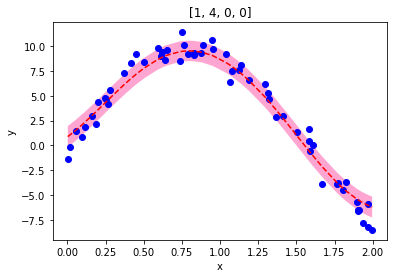

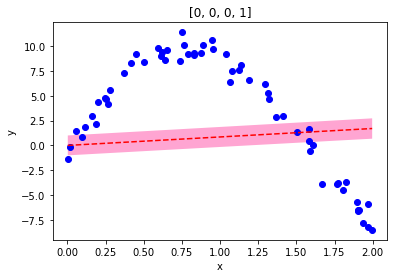

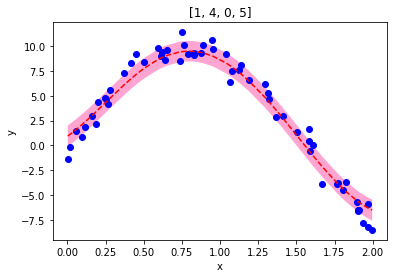

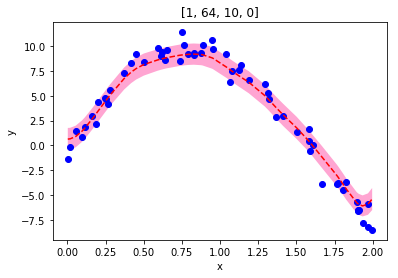

In [20]:
# calculate mu & sd on training-set

def ReturnTheta(lst):
    return lst[0],lst[1],lst[2],lst[3]

RMS_ary_tr = {}
for name, kernel in kernel_dic.items():
    tr_N = len(x_tr)
    K_mat = np.zeros((tr_N,tr_N))
    Cov_mat = np.zeros((tr_N,tr_N))
    I_mat = np.identity(tr_N)
    for i in range(tr_N):
        for j in range(tr_N):
            theta0, theta1, theta2, theta3 = ReturnTheta(kernel)
            K_mat[i][j] = theta0*np.exp(-theta1 * (x_tr[i]-x_tr[j])**2 /2) + theta2 + theta3*x_tr[i]*x_tr[j] # note in exp part, it's 2-norm not simply square!
            Cov_mat[i][j] = K_mat[i][j] + beta*I_mat[i][j]


    ## start calculate predictive mu & var.
    cov_ary = np.zeros(tr_N)
    scalar_c = np.zeros(tr_N)

    mu_ary = np.dot(np.dot(K_mat,inv(Cov_mat)),t_tr)
    for i in range(len(scalar_c)):
        scalar_c[i] = K_mat[i][i] + beta
    for i in range(len(cov_ary)):
        cov_ary[i] = scalar_c[i] - np.dot(np.dot(K_mat[i],inv(Cov_mat)),K_mat[i].T)
    sd = np.sqrt(cov_ary)
    mu_ary = mu_ary.reshape(1,-1)[0]
    x_tr = np.array(x_tr).reshape(1,-1)[0]

    import matplotlib.pyplot as plt

    plt.plot(x_tr, t_tr, 'bo')
    plt.plot(x_tr, mu_ary, 'r--')
    plt.fill_between(x_tr, mu_ary-sd, mu_ary+sd,facecolor='#ffa5d2')
    plt.title(str(kernel))
    plt.xlabel('x')
    plt.ylabel('y')
    
    # save fig
#     plt.savefig('./1_1_kernel_%s.png'%name)
    
    # show
    plt.show()
    
    
    #cal RMS
    val = 0
    for i in range(tr_N):
        val += (mu_ary[i]-t_tr[i])**2
    val = np.sqrt(val/tr_N)
    
    RMS_ary_tr[name] = val
    

In [18]:
# calculate mu & sd on testing-set

RMS_ary_ts = {}
for name, kernel in kernel_dic.items():
    ts_N = len(x_ts)
    K_mat = np.zeros((ts_N,ts_N))
    Cov_mat = np.zeros((ts_N,ts_N))
    I_mat = np.identity(ts_N)
    for i in range(ts_N):
        for j in range(ts_N):
            theta0, theta1, theta2, theta3 = ReturnTheta(kernel)
            K_mat[i][j] = theta0*np.exp(-theta1 * (x_ts[i]-x_ts[j])**2 /2) + theta2 + theta3*x_ts[i]*x_ts[j] # note in exp part, it's 2-norm not simply square!
            Cov_mat[i][j] = K_mat[i][j] + beta*I_mat[i][j]


    ## start calculate predictive mu & var.
    cov_ary = np.zeros(ts_N)
    scalar_c = np.zeros(ts_N)

    mu_ary = np.dot(np.dot(K_mat,inv(Cov_mat)),t_ts)
    for i in range(len(scalar_c)):
        scalar_c[i] = K_mat[i][i] + beta
    for i in range(len(cov_ary)):
        cov_ary[i] = scalar_c[i] - np.dot(np.dot(K_mat[i],inv(Cov_mat)),K_mat[i].T)
    sd = np.sqrt(cov_ary)
    mu_ary = mu_ary.reshape(1,-1)[0]
    x_ts = np.array(x_ts).reshape(1,-1)[0]

    import matplotlib.pyplot as plt

    plt.plot(x_ts, t_ts, 'bo')
    plt.plot(x_ts, mu_ary, 'r--')
    plt.fill_between(x_ts, mu_ary-sd, mu_ary+sd,facecolor='#ffa5d2')
    plt.title(str(kernel))
    plt.xlabel('x')
    plt.ylabel('y')

    # show
    # plt.show()
    
    #cal RMS
    val = 0
    for i in range(ts_N):
        val += (mu_ary[i]-t_ts[i])**2
    val = np.sqrt(val/ts_N)
    
    RMS_ary_ts[name] = val


In [5]:
# RMS
print('======= For training =======')
for key, val in RMS_ary_tr.items():
    print('%s(%s) : RMS = %s \n' % (key, kernel_dic[key], str(val)))
print('\n======= For testing =======')
for key, val in RMS_ary_ts.items():
    print('%s(%s) : RMS = %s \n' % (key, kernel_dic[key], str(val)))

======= For training =======
sqr_exp_kernel([1, 4, 0, 0]) : RMS = [ 1.05224307] 

linear_kernel([0, 0, 0, 1]) : RMS = [ 6.65758954] 

exp_quadra_kernel([1, 4, 0, 5]) : RMS = [ 1.0288404] 

exp_quadra_kernel_2([1, 64, 10, 0]) : RMS = [ 1.03287726] 


======= For testing =======
sqr_exp_kernel([1, 4, 0, 0]) : RMS = [ 1.31972289] 

linear_kernel([0, 0, 0, 1]) : RMS = [ 6.63431273] 

exp_quadra_kernel([1, 4, 0, 5]) : RMS = [ 1.2842308] 

exp_quadra_kernel_2([1, 64, 10, 0]) : RMS = [ 1.38904624] 



## Automatic Relevance Determination

[ 3.07505549]
[ 6.00474178]
[ 4.00100348]
[ 5.00010603]
[ 3.14667612]
[ 6.00924599]
[ 4.00195813]
[ 5.00019618]
[ 3.21523042]
[ 6.01353248]
[ 4.00286838]
[ 5.00027183]
[ 3.28102703]
[ 6.01761836]
[ 4.00373803]
[ 5.00033417]
[ 3.34432736]
[ 6.02151853]
[ 4.00457033]
[ 5.00038422]
[ 3.40535505]
[ 6.02524607]
[ 4.00536813]
[ 5.0004229]
[ 3.46430312]
[ 6.02881253]
[ 4.00613393]
[ 5.00045099]
Best-Theta =  [array([ 3.46430312]), array([ 6.02881253]), array([ 4.00613393]), array([ 5.00045099])]


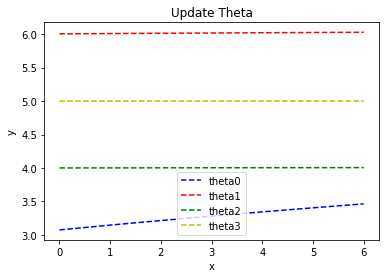

In [13]:
#Modify hyperparameters

ini_theta = [3.0, 6.0, 4.0, 5.0]
lr = 0.01

tr_N = len(x_tr)
K_mat = np.zeros((tr_N,tr_N))
Cov_mat = np.zeros((tr_N,tr_N))
I_mat = np.identity(tr_N)

t_tr = np.array(t_tr)
t_tr_T = np.array(t_tr).T[0]

X_tr_mat = np.array([x_tr,]*tr_N)

theta0, theta1, theta2, theta3 = ReturnTheta(ini_theta)
update_theta0 = np.float('Inf')
update_theta1 = np.float('Inf')
update_theta2 = np.float('Inf')
update_theta3 = np.float('Inf')

theta0_lst = []
theta1_lst = []
theta2_lst = []
theta3_lst = []
iter_lst = []
iterNum = 0
while update_theta0>=6 or update_theta1>=6 or update_theta2>=6 or update_theta3>=6 :
    iter_lst.append(iterNum)
    for i in range(tr_N):
        for j in range(tr_N):

            K_mat[i][j] = theta0*np.exp(-theta1 * (x_tr[i]-x_tr[j])**2 /2) + theta2 + theta3*x_tr[i]*x_tr[j] # note in exp part, it's 2-norm not simply square!
            Cov_mat[i][j] = K_mat[i][j] + beta*I_mat[i][j]

    #print(theta0,theta1,theta2,theta3)

    dC_dt0 = np.exp(-0.5 * theta1 * (X_tr_mat - X_tr_mat.T)**2)
    dC_de1 = -0.5 * theta0 * (X_tr_mat - X_tr_mat.T)**2 * np.exp(-0.5 * theta1 * (X_tr_mat - X_tr_mat.T)**2)
    dC_dt2 = np.ones_like(X_tr_mat)
    dC_dt3 = X_tr_mat * X_tr_mat.T

    update_theta0 = (-0.5*np.trace(np.dot(inv(Cov_mat),dC_dt0)) + 0.5*np.dot(np.dot(np.dot(t_tr_T,inv(Cov_mat)),dC_dt0),np.dot(inv(Cov_mat),t_tr)))
    update_theta1 = (-0.5*np.trace(np.dot(inv(Cov_mat),dC_de1)) + 0.5*np.dot(np.dot(np.dot(t_tr_T,inv(Cov_mat)),dC_de1),np.dot(inv(Cov_mat),t_tr)))
    update_theta2 = (-0.5*np.trace(np.dot(inv(Cov_mat),dC_dt2)) + 0.5*np.dot(np.dot(np.dot(t_tr_T,inv(Cov_mat)),dC_dt2),np.dot(inv(Cov_mat),t_tr)))
    update_theta3 = (-0.5*np.trace(np.dot(inv(Cov_mat),dC_dt3)) + 0.5*np.dot(np.dot(np.dot(t_tr_T,inv(Cov_mat)),dC_dt3),np.dot(inv(Cov_mat),t_tr)))

    new_theta0 = theta0 + lr* update_theta0
    new_theta1 = theta1 + lr* update_theta1
    new_theta2 = theta2 + lr* update_theta2
    new_theta3 = theta3 + lr* update_theta3
        
    theta0 = new_theta0
    theta1 = new_theta1
    theta2 = new_theta2
    theta3 = new_theta3
    
#     print(update_theta0,update_theta1,update_theta2,update_theta3)
    print(theta0)
    print(theta1)
    print(theta2)
    print(theta3)
    print('================')
    
    theta0_lst.append(theta0)
    theta1_lst.append(theta1)
    theta2_lst.append(theta2)
    theta3_lst.append(theta3)
    
    iterNum += 1
        
Best_theta = [theta0,theta1,theta2,theta3]
print('Best-Theta = ',Best_theta)

plt.close
plt.plot(iter_lst, theta0_lst,  'b--',label = 'theta0')
plt.plot(iter_lst, theta1_lst, 'r--',label = 'theta1')
plt.plot(iter_lst, theta2_lst,  'g--',label = 'theta2')
plt.plot(iter_lst, theta3_lst,  'y--',label = 'theta3')
plt.legend()
plt.title('Update Theta')
plt.xlabel('x')
plt.ylabel('y')

# save fig
# plt.savefig('./Update-Theta.png')

plt.show()

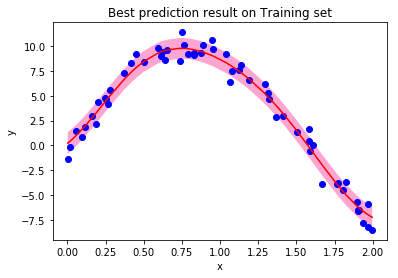

In [21]:
# calculate mu & sd on training-set

def ReturnTheta(lst):
    return lst[0],lst[1],lst[2],lst[3]

RMS_ary_tr = {}
kernel_dic = {'best_theta':Best_theta}
for name, kernel in kernel_dic.items():
    tr_N = len(x_tr)
    K_mat = np.zeros((tr_N,tr_N))
    Cov_mat = np.zeros((tr_N,tr_N))
    I_mat = np.identity(tr_N)
    for i in range(tr_N):
        for j in range(tr_N):
            theta0, theta1, theta2, theta3 = ReturnTheta(kernel)
            K_mat[i][j] = theta0*np.exp(-theta1 * (x_tr[i]-x_tr[j])**2 /2) + theta2 + theta3*x_tr[i]*x_tr[j] # note in exp part, it's 2-norm not simply square!
            Cov_mat[i][j] = K_mat[i][j] + beta*I_mat[i][j]


    ## start calculate predictive mu & var.
    cov_ary = np.zeros(tr_N)
    scalar_c = np.zeros(tr_N)

    mu_ary = np.dot(np.dot(K_mat,inv(Cov_mat)),t_tr)
    for i in range(len(scalar_c)):
        scalar_c[i] = K_mat[i][i] + beta
    for i in range(len(cov_ary)):
        cov_ary[i] = scalar_c[i] - np.dot(np.dot(K_mat[i],inv(Cov_mat)),K_mat[i].T)
    sd = np.sqrt(cov_ary)
    mu_ary = mu_ary.reshape(1,-1)[0]
    x_tr = np.array(x_tr).reshape(1,-1)[0]

    import matplotlib.pyplot as plt

    plt.plot(x_tr, t_tr, 'bo')
    plt.plot(x_tr, mu_ary, 'r')
    plt.fill_between(x_tr, mu_ary-sd, mu_ary+sd,facecolor='#ffa5d2')
    plt.title('Best prediction result on Training set')
    plt.xlabel('x')
    plt.ylabel('y')
    
    # save fig
#     plt.savefig('./Best_prediction_result_on_Training_set.png')
    
    plt.show()
    
    
    #cal RMS
    val = 0
    for i in range(tr_N):
        val += (mu_ary[i]-t_tr[i])**2
    val = np.sqrt(val/tr_N)
    
    RMS_ary_tr[name] = val
    

In [8]:
# calculate mu & sd on testing-set

RMS_ary_ts = {}
kernel_dic = {'best_theta':Best_theta}
for name, kernel in kernel_dic.items():
    ts_N = len(x_ts)
    K_mat = np.zeros((ts_N,ts_N))
    Cov_mat = np.zeros((ts_N,ts_N))
    I_mat = np.identity(ts_N)
    for i in range(ts_N):
        for j in range(ts_N):
            theta0, theta1, theta2, theta3 = ReturnTheta(kernel)
            K_mat[i][j] = theta0*np.exp(-theta1 * (x_ts[i]-x_ts[j])**2 /2) + theta2 + theta3*x_ts[i]*x_ts[j] # note in exp part, it's 2-norm not simply square!
            Cov_mat[i][j] = K_mat[i][j] + beta*I_mat[i][j]


    ## start calculate predictive mu & var.
    cov_ary = np.zeros(ts_N)
    scalar_c = np.zeros(ts_N)

    mu_ary = np.dot(np.dot(K_mat,inv(Cov_mat)),t_ts)
    for i in range(len(scalar_c)):
        scalar_c[i] = K_mat[i][i] + beta
    for i in range(len(cov_ary)):
        cov_ary[i] = scalar_c[i] - np.dot(np.dot(K_mat[i],inv(Cov_mat)),K_mat[i].T)
    sd = np.sqrt(cov_ary)
    mu_ary = mu_ary.reshape(1,-1)[0]
    x_ts = np.array(x_ts).reshape(1,-1)[0]

    import matplotlib.pyplot as plt

    plt.plot(x_ts, t_ts, 'bo')
    plt.plot(x_ts, mu_ary, 'r--')
    plt.fill_between(x_ts, mu_ary-sd, mu_ary+sd,facecolor='#ffa5d2')
    plt.title(name)
    plt.xlabel('x')
    plt.ylabel('y')
#     plt.show()
    
    #cal RMS
    val = 0
    for i in range(ts_N):
        val += (mu_ary[i]-t_ts[i])**2
    val = np.sqrt(val/ts_N)
    
    RMS_ary_ts[name] = val

In [9]:
# RMS
print('Best RMS for training = ',RMS_ary_tr.values())
print('Best RMS for testing = ',RMS_ary_ts.values())

Best RMS for training =  dict_values([array([ 0.83939913])])
Best RMS for testing =  dict_values([array([ 1.07229143])])


## Compare with Bayesian linear regression result 

In [10]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

M = 7
s = 0.1
beta = 1
alpha = 10e-6
Ns = [60] # total 60 points
mN_ary = np.zeros((len(Ns),M))
SN_ary = np.zeros((len(Ns),M,M))
Phi_ary = []


# xx = x[:N] # shape: (N,1)
# tt = t[:N] # shape: (N,1)

idx = 0
N = Ns[0]

## first compute Φ matrix
Phi_T = np.zeros((M,N))
for j in range(M):
    a_ary = (x_tr.reshape(1,-1)[0] - (2*j/M))/s # a = x-uj/s
    phi_j = [sigmoid(a) for a in a_ary]
    Phi_T[j] = phi_j

Phi = Phi_T.T
Phi_ary.append(Phi)

## calculate m_N, S_N
identity_mat = alpha*np.identity(M)
phi_square = beta*np.dot(Phi_T,Phi)
SN_inverse = identity_mat + phi_square
SN = inv(SN_inverse)
mN = np.dot( np.dot( beta*SN, Phi_T), t_tr)
print('N = ',N)
print('mN vector = ', mN.reshape(1,-1)[0])
print('SN matrix = ', SN)

mN_ary[idx] = mN.reshape(1,-1)
SN_ary[idx] = SN
print('===================================================')

N =  60
mN vector =  [ -0.20820087  11.14577113  -1.89423467   1.51736591  -5.80361051
  -3.18427484  -9.31685814]
SN matrix =  [[ 0.50521439 -0.97157076  0.69900395 -0.35731484  0.18815703 -0.0881944
   0.02900072]
 [-0.97157076  2.40029127 -2.22297691  1.23499955 -0.667114    0.31462652
  -0.10361055]
 [ 0.69900395 -2.22297691  2.84903883 -2.1995613   1.34385259 -0.65423907
   0.21713059]
 [-0.35731484  1.23499955 -2.1995613   2.76222224 -2.34427001  1.27461429
  -0.43601728]
 [ 0.18815703 -0.667114    1.34385259 -2.34427001  3.02168681 -2.28327665
   0.8773786 ]
 [-0.0881944   0.31462652 -0.65423907  1.27461429 -2.28327665  2.62301657
  -1.44428674]
 [ 0.02900072 -0.10361055  0.21713059 -0.43601728  0.8773786  -1.44428674
   1.18145787]]


(100,)


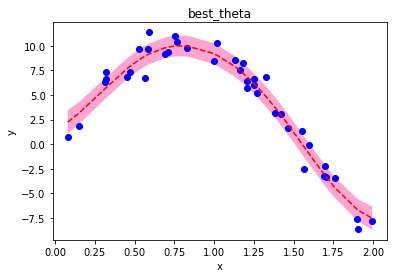

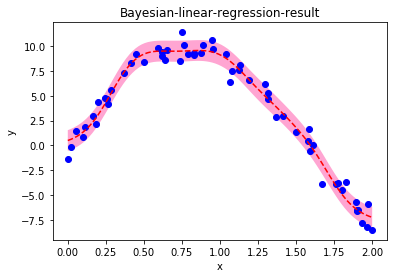

RMS on Bayesian linear regression result =  [ 7.36480426]


In [11]:
for idx, N in enumerate(Ns):
    mean, cov = mN_ary[idx], SN_ary[idx]
#     PHI = Phi_ary[idx] # N*M
    data = x[:N]
    
    plt.figure(idx)
    
    # plot target value t given from data
    target = [x for _,x in sorted(zip(data,t[:N]))]
    plt.plot(sorted(data), target, 'bo')
    
    # plot mean curve
    mean_ary = []
    for nn in range(100):
        xx = np.linspace(0, 2, 100)
        Phi_T = np.zeros((M,100))
        for j in range(M):
            a_ary = (xx.reshape(1,-1)[0] - (2*j/M))/s # a = x-uj/s
            phi_j = [sigmoid(a) for a in a_ary]
            Phi_T[j] = phi_j

        Phi = Phi_T.T
        mean_ary.append(np.dot(mean.T,Phi[nn].T))
    plt.plot(xx, mean_ary, 'r--')#,x[:N].reshape(1,-1)[0], t[:N], 'bs')
    
    # plot variance region
    variance = []
    for nn in range(100):
        xx = np.linspace(0, 2, 100)
        Phi_T = np.zeros((M,100))
        for j in range(M):
            a_ary = (xx.reshape(1,-1)[0] - (2*j/M))/s # a = x-uj/s
            phi_j = [sigmoid(a) for a in a_ary]
            Phi_T[j] = phi_j

        Phi = Phi_T.T
        variance.append(1.0/beta + np.dot( np.dot(Phi[nn],cov), Phi[nn].T))
    sd = np.sqrt(variance)
    print((mean_ary-sd).shape)
#     print(stop)
    plt.fill_between(xx, mean_ary-sd, mean_ary+sd, facecolor='#ffa5d2')
    
    # plot
    plt.title('Bayesian-linear-regression-result') 
    plt.xlabel('x')
    plt.ylabel('y')
    
    # save fig
    # plt.savefig('2_3_N_%s.png'%str(N))
    
# plt.savefig('Baysian.png')
plt.show()

#cal RMS
val = 0
for i in range(tr_N):
    val += (mean_ary[i]-t_tr[i])**2
val = np.sqrt(val/tr_N)

RMS = val
print('RMS on Bayesian linear regression result = ',RMS)

In [12]:
# # export to python file
#!jupyter nbconvert --to python Problem1_Gaussian_Process_Regression.ipynb